## Proyek Klasifikasi: Prediksi Customer Churn
**Nama**: Melshita Ardia Kirana

**Email**: mc006d5x1408@student.devacademy.id

**ID Dicoding:** MC006D5X1408

**Sumber Dataset:**

Dataset yang digunakan berasal dari platform Kaggle dengan nama:
Telco Customer Churn Dataset
Link: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Dataset ini berisi informasi pelanggan dari perusahaan telekomunikasi fiktif, dan sangat sering digunakan sebagai studi kasus prediksi churn dalam industri telekomunikasi.


## 1. Import Library

Pada tahap ini dilakukan import library yang dibutuhkan, seperti:

- **pandas, numpy:** untuk manipulasi data

- **matplotlib, seaborn:** visualisasi

- **sklearn, xgboost:** untuk preprocessing dan modeling



In [13]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Preparation

Dataset dimuat dari Google Drive. Setelah itu ditampilkan beberapa baris awal untuk memahami struktur data.

Kita juga menampilkan jumlah baris dan kolom sebagai bagian dari pemahaman awal data.

In [2]:
file_path = '/content/drive/MyDrive/Dicoding/Project Machine Learning Terapan/Proyek Pertama/dataset_TelcoCust.csv'
df = pd.read_csv(file_path)
df.head()

# Tampilkan jumlah baris dan kolom
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")

Jumlah baris: 7043
Jumlah kolom: 21


Untuk memahami kondisi awal dataset, dilakukan pengecekan jumlah nilai kosong, data duplikat, dan statistik deskriptif sebagai berikut:

In [3]:
# Cek missing values
print("Jumlah missing value per kolom:")
print(df.isnull().sum())

# Cek data duplikat
print("\nJumlah data duplikat:")
print(df.duplicated().sum())

# Statistik deskriptif untuk overview numerik
print("\nStatistik deskriptif:")
print(df.describe())

Jumlah missing value per kolom:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Jumlah data duplikat:
0

Statistik deskriptif:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.75

## 3. Data Preprocessing

### Data Cleaning

#### Penanganan Missing Value dan Tipe Data
Kolom TotalCharges perlu diubah ke tipe numerik karena terdapat spasi kosong. Missing value akan dihapus karena jumlahnya sedikit.

In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

#### Penghapusan Kolom Tidak Relevan

Kolom customerID tidak memiliki kontribusi dalam model prediksi dan dihapus untuk menghindari noise.

In [5]:
df.drop(['customerID'], axis=1, inplace=True, errors='ignore')  # menghapus kolom ID

#### Encoding dan Normalisasi


In [6]:
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = [col for col in df.columns if col not in num_cols + ['Churn']]

df_encoded = pd.get_dummies(df, columns=cat_cols)

scaler = MinMaxScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

## 4. Data Splitting

Data dibagi menjadi:

- **Training set:** 80%

- **Test set:** 20%

Dengan stratifikasi berdasarkan label Churn agar proporsi kelas tetap terjaga.

In [7]:
# Split data menjadi data train dan test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Ukuran data train:", X_train.shape)
print("Ukuran data test:", X_test.shape)

Ukuran data train: (5625, 46)
Ukuran data test: (1407, 46)


## 5. Modeling

Dilakukan pelatihan 5 algoritma klasifikasi:

1. Logistic Regression

2. Random Forest Classifier

3. Support Vector Machine

4. XGBoost Classifier

5. K-Nearest Neighbors

Setiap model di-fit pada data training. Parameter dasar digunakan, kecuali XGBoost diatur agar early stopping aktif untuk menghindari overfitting.

In [8]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

trained_models = {}

# Training semua model
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"Model {name} telah dilatih.")

Model Logistic Regression telah dilatih.
Model Random Forest telah dilatih.
Model Support Vector Machine telah dilatih.
Model XGBoost telah dilatih.
Model K-Nearest Neighbors telah dilatih.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 6. Evaluasi dan Visualisasi

Model dievaluasi menggunakan metrik:

- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC

ROC Curve digunakan untuk membandingkan performa model dalam membedakan kelas.

Confusion Matrix divisualisasikan untuk masing-masing model guna melihat performa klasifikasi positif dan negatif.

Untuk analisis interpretabilitas:
- Koefisien Logistic Regression divisualisasikan sebagai fitur penting.
- SHAP digunakan untuk menjelaskan kontribusi fitur terhadap prediksi.

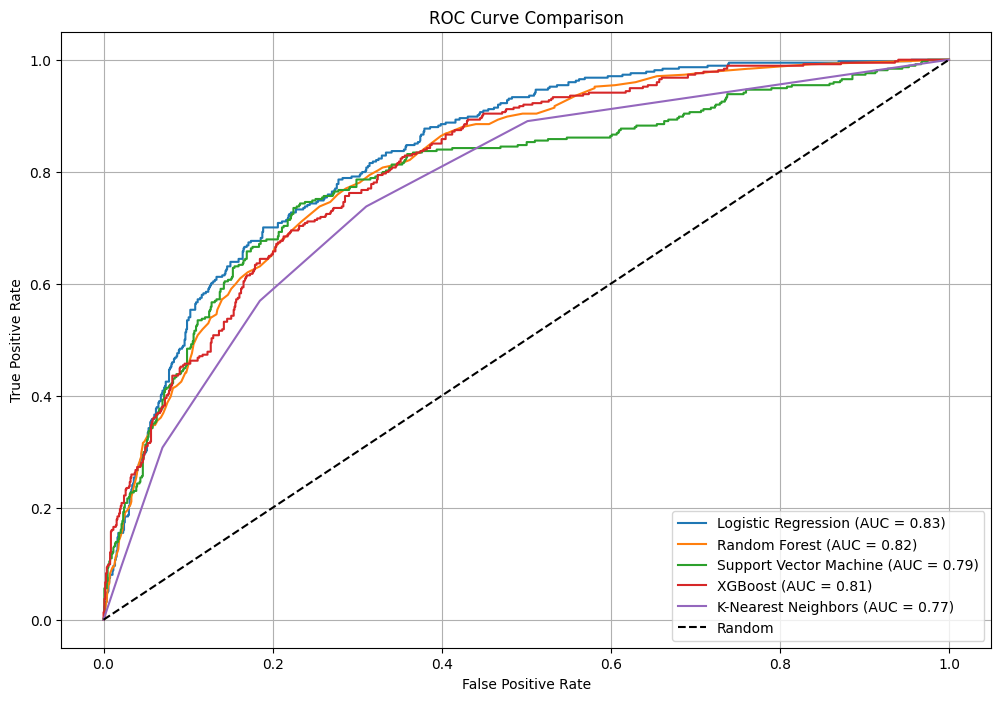


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



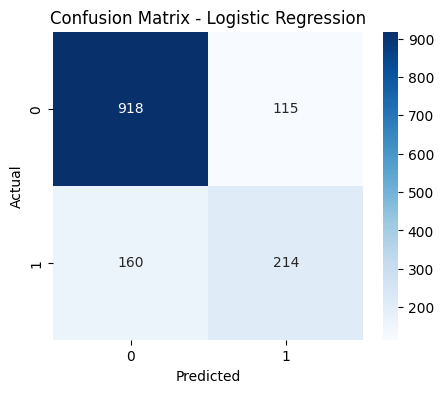


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



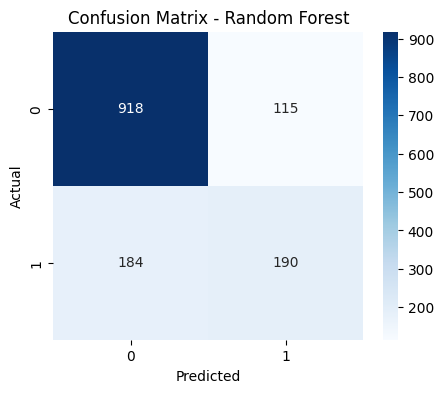


=== Support Vector Machine ===
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



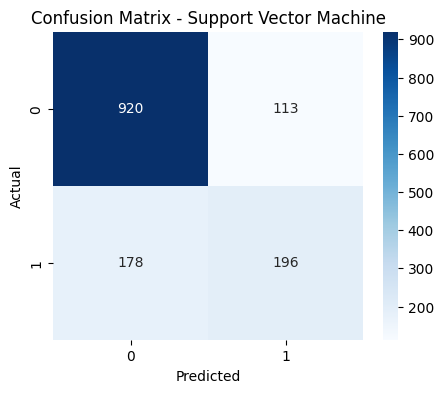


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1033
           1       0.57      0.52      0.54       374

    accuracy                           0.77      1407
   macro avg       0.70      0.69      0.69      1407
weighted avg       0.76      0.77      0.76      1407



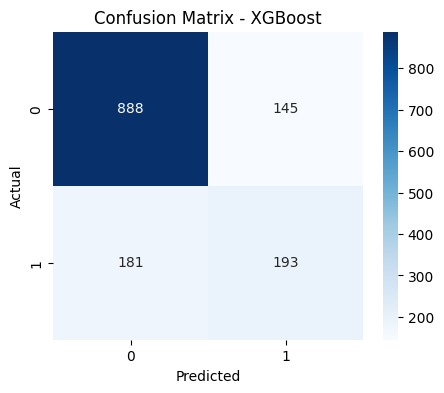


=== K-Nearest Neighbors ===
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1033
           1       0.53      0.57      0.55       374

    accuracy                           0.75      1407
   macro avg       0.68      0.69      0.69      1407
weighted avg       0.76      0.75      0.75      1407



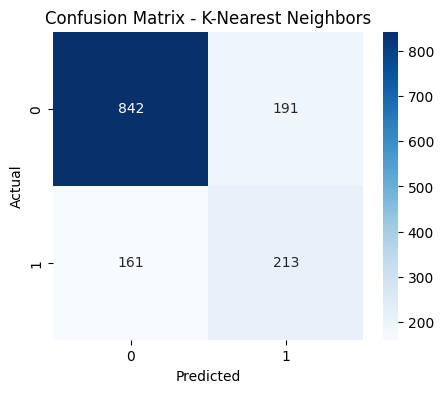

In [20]:
plt.figure(figsize=(12, 8))

# Visualisasi ROC Curve
for name, model in trained_models.items():
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Evaluasi lebih detail
for name, model in trained_models.items():
    print(f"\n=== {name} ===")
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

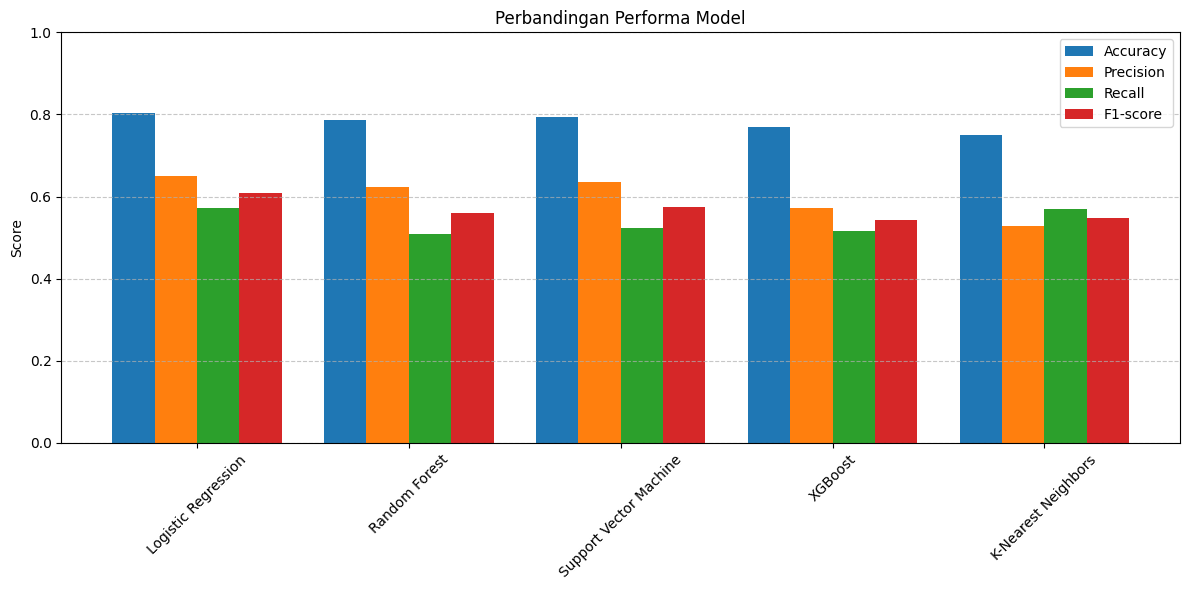

In [21]:
# Simpan hasil evaluasi semua model
performance = []

for name, model in trained_models.items():
    preds = model.predict(X_test)
    performance.append([
        name,
        accuracy_score(y_test, preds),
        precision_score(y_test, preds),
        recall_score(y_test, preds),
        f1_score(y_test, preds)
    ])

# Buat DataFrame
performance_df = pd.DataFrame(
    performance,
    columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']
)

# Plot grouped bar chart
labels = performance_df['Model']
x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, performance_df['Accuracy'], width, label='Accuracy')
plt.bar(x - 0.5*width, performance_df['Precision'], width, label='Precision')
plt.bar(x + 0.5*width, performance_df['Recall'], width, label='Recall')
plt.bar(x + 1.5*width, performance_df['F1-score'], width, label='F1-score')

plt.xticks(x, labels, rotation=45)
plt.ylabel('Score')
plt.title('Perbandingan Performa Model')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-22-9ed2611f3cf6>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette='viridis')


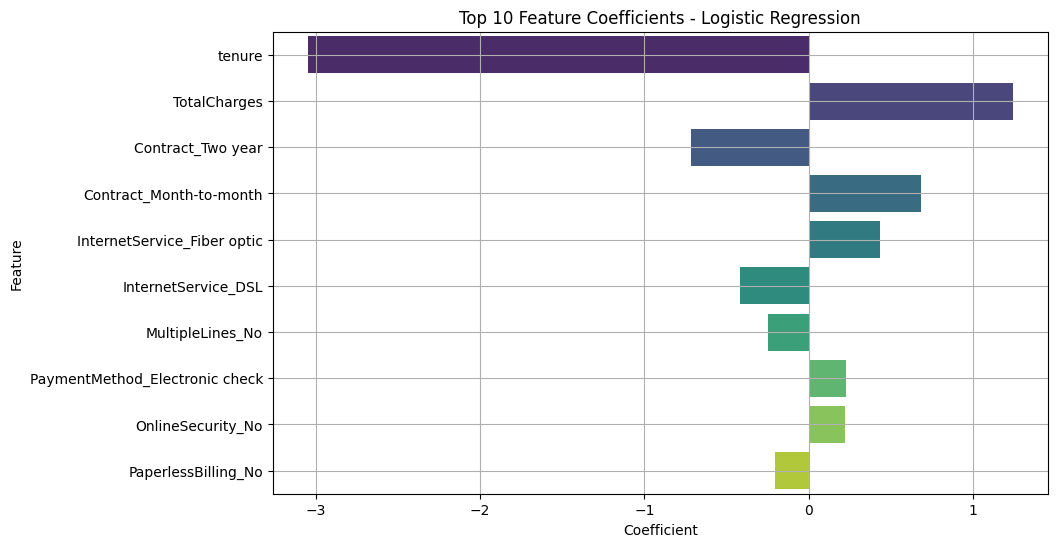

In [22]:
# Visualisasi Koefisien Logistic Regression sebagai Feature Importance
coefficients = trained_models['Logistic Regression'].coef_[0]
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 10 Feature Coefficients - Logistic Regression')
plt.grid()
plt.show()

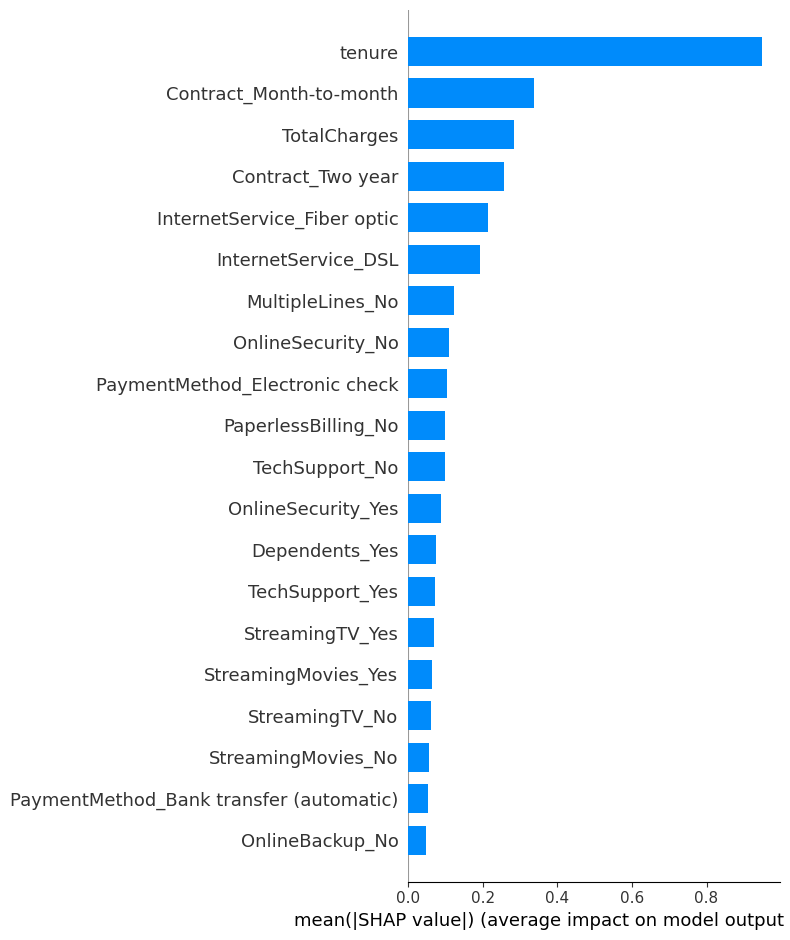

In [23]:
# SHAP Linear Explainer (tanpa feature_perturbation)
explainer = shap.LinearExplainer(
    trained_models['Logistic Regression'],
    X_train
)

shap_values = explainer.shap_values(X_test)

shap_values = shap_values.astype(np.float64)

if np.isnan(shap_values).any() or np.isinf(shap_values).any():
    print("Peringatan: Ditemukan nilai NaN atau Inf dalam shap_values. Menggantinya dengan nilai median.")

    for i in range(shap_values.shape[1]):
        column_values = shap_values[:, i]
        finite_values = column_values[np.isfinite(column_values)]
        if finite_values.size > 0:
            median_val = np.median(finite_values)
            shap_values[np.isnan(column_values), i] = median_val
            shap_values[np.isinf(column_values), i] = median_val
        else:
             shap_values[:, i] = 0

# Summary plot bar dan scatter
shap.summary_plot(shap_values, X_test, plot_type="bar")

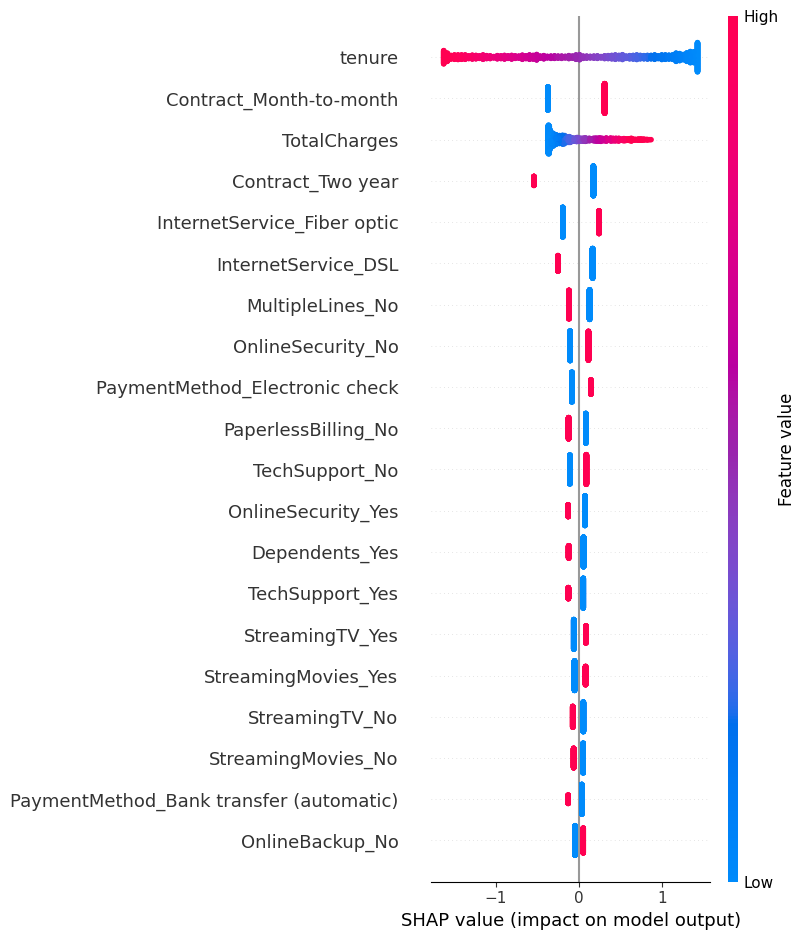

In [24]:
shap.summary_plot(shap_values, X_test)

## 7. Konversi Model

Model Logistic Regression dipilih sebagai model terbaik berdasarkan keseimbangan antara metrik, interpretabilitas, dan stabilitas. Model ini kemudian disimpan ke file `.pkl` untuk keperluan deployment dan inference.


In [25]:
# Simpan model terbaik (Logistic Regression)
best_model = trained_models['Logistic Regression']
model_path = '/content/drive/MyDrive/Dicoding/Project Machine Learning Terapan/Proyek Pertama/model_churn_logreg.pkl'
joblib.dump(best_model, model_path)

print(f"Model berhasil disimpan di {model_path}")

Model berhasil disimpan di /content/drive/MyDrive/Dicoding/Project Machine Learning Terapan/Proyek Pertama/model_churn_logreg.pkl


## 8. Inference

Model yang telah disimpan di-load kembali. Prediksi dilakukan terhadap 5 sampel dari data uji. Hasil prediksi, probabilitas churn, dan label aktual ditampilkan dalam bentuk tabel.

Tujuan tahap ini adalah memvalidasi penggunaan model dalam skenario nyata.


In [26]:
# Load model yang telah disimpan
loaded_model = joblib.load(model_path)

# Contoh inference: Ambil 5 sample dari test set
sample = X_test.sample(5, random_state=1)
true_labels = y_test.loc[sample.index]

# Prediksi
predictions = loaded_model.predict(sample)
probs = loaded_model.predict_proba(sample)[:, 1]

# Tampilkan hasil
result_df = pd.DataFrame({
    'Predicted': predictions,
    'Probability (Churn)': probs,
    'Actual': true_labels.values
}, index=sample.index)

print("Hasil Inference:")
print(result_df)

Hasil Inference:
      Predicted  Probability (Churn)  Actual
458           0             0.183904       0
3327          0             0.138769       0
5104          0             0.029318       0
5089          0             0.432199       0
3377          0             0.005246       0


## 9. Kesimpulan

- Model **Logistic Regression** memberikan performa terbaik dengan **F1-score tertinggi** untuk kelas churn, serta akurasi yang stabil dan metrik yang seimbang. Ini menunjukkan bahwa model cukup andal untuk memprediksi pelanggan yang kemungkinan akan berhenti berlangganan.

- Meskipun beberapa model seperti Random Forest dan SVM memberikan hasil mendekati Logistic Regression, Logistic Regression memiliki keunggulan pada **presisi dan f1-score untuk pelanggan churn**, yang merupakan fokus utama bisnis.

- Hasil inference menunjukkan bahwa model mampu mengidentifikasi pelanggan yang tidak akan churn dengan **keyakinan probabilitas yang akurat dan konsisten**. Contoh inference pada 5 data uji menunjukkan bahwa semua pelanggan diprediksi tidak churn (label 0) dan cocok dengan nilai aktual, dengan probabilitas churn yang relatif rendah (di bawah 0.5).

- Model Logistic Regression siap digunakan dalam proses prediksi churn, dan dapat membantu perusahaan dalam merancang strategi retensi pelanggan secara efektif.